In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.7.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetA_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetA_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
Control_Compo[Control_Compo["ABC"] == "A"]

,Orig Index,ABC,Time,Lon,Lat,PathID
0,0,A,1985-06-19 12:00:00,-82.19,27.99,0
1,1,A,1985-06-19 18:00:00,-82.26,27.79,0
2,2,A,1985-06-20 00:00:00,-82.33,27.58,0
3,3,A,1985-06-20 06:00:00,-82.40,27.38,0
4,4,A,1985-06-20 12:00:00,-82.46,28.31,0
...,...,...,...,...,...,...
10154,10154,A,2014-11-11 06:00:00,-76.86,26.37,306
10155,10155,A,2014-11-11 12:00:00,-75.85,27.61,306
10156,10156,A,2014-11-11 18:00:00,-74.54,29.19,306
10157,10157,A,2014-11-12 00:00:00,-73.07,32.06,306


In [20]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
#    print (Year_Orig)
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [21]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [22]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    Code_List = DF_Storm["Code"]
    Name_List = DF_Storm["Name"]
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Code": Code_List, "Name": Name_List, \
    "Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP": SLP, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [23]:
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [24]:
# Find Total Precip Rate From Compo File
def Precip(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [25]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    SLP = DF_Storm_Compo["SLP"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((5,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
# Count Number of Data Points With Windspeed Above 18,25,33m/s
        Snap_Sort = numpy.sort(Snap_850.ravel())
        Count_18 = len(Snap_Sort[Snap_Sort >= 18])
        Count_25 = len(Snap_Sort[Snap_Sort >= 25])
        Count_33 = len(Snap_Sort[Snap_Sort >= 33])
        Wind_Field_Info[2][k] = Count_18
        Wind_Field_Info[3][k] = Count_25
        Wind_Field_Info[4][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    DF_Storm_Compo["18m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["25m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["33m/s"] = Wind_Field_Info[4]
    return (DF_Storm_Compo)

In [26]:
# Find Max Precip and Total Precip Over Area
def Precip_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
#
# Create Array to Store Data
    Precip_Field_Info = numpy.zeros((5,len(Compo_Index)))
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Precip Snap From Compo_nc
        Snap_Precip = Precip(Compo_nc, Compo_Index[k])
# Find Maximum Precip Rate
        Max_Precip = numpy.max(Snap_Precip)
        Precip_Field_Info[0][k] = Max_Precip
# Find Areal Precip Total
        Snap_Sort = numpy.sort(Snap_Precip.ravel())
        Areal_Precip_Total = numpy.sum(Snap_Sort)
        Precip_Field_Info[1][k] = Areal_Precip_Total
# Count Number of Data Points With Precip Rate Above 0.5, 1, 5mm/hr
        Count_05 = len(Snap_Sort[Snap_Sort >= 0.5])
        Count_1 = len(Snap_Sort[Snap_Sort >= 1])
        Count_5 = len(Snap_Sort[Snap_Sort >= 5])
        Precip_Field_Info[2][k] = Count_05
        Precip_Field_Info[3][k] = Count_1
        Precip_Field_Info[4][k] = Count_5
# 
# Add Precip Field Info Into DF Storm Compo
    DF_Storm_Compo["Max Precip Rate"] = Precip_Field_Info[0]
    DF_Storm_Compo["Areal Precip Total"] = Precip_Field_Info[1]
    DF_Storm_Compo["0.5mm/hr"] = Precip_Field_Info[2]
    DF_Storm_Compo["1mm/hr"] = Precip_Field_Info[3]
    DF_Storm_Compo["5mm/hr"] = Precip_Field_Info[4]
    return (DF_Storm_Compo)

In [27]:
# Create New Data DF
def DF_Data_Compo(Data_DF, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C):
    Code_List = ET_DF["Code"]
    ABC_List = ET_DF["ABC"]
# Loop Over Each Storm in Dataset
    for n in range(len(Code_List)):
        DF_Storm_Compo = Find_Composite_Data(Code_List[n], Data_DF, Compo_DF)
# Find Which Compo nc To Use
        if ABC_List[n] == "A":
            Compo_nc = Compo_nc_A
        elif ABC_List[n] == "B":
            Compo_nc = Compo_nc_B
        elif ABC_List[n] == "C":
            Compo_nc = Compo_nc_C
# Apply Functions For Finding Wind Field and Precip Field
        DF_Storm_Compo = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
        DF_Storm_Compo = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
# Only Keep Storms With Complete ET Data
        if len(DF_Storm_Compo) > 0:
            if DF_Storm_Compo["Storm Phase"][len(DF_Storm_Compo)-1] == "Extratropical":
# Combine DF Storm Compos
                try:
                    Data_Compo = pandas.concat([Data_Compo, DF_Storm_Compo])
                except:
                    Data_Compo = DF_Storm_Compo.copy()
    Data_Compo_Final = Data_Compo.reset_index().drop("index", axis=1)
    return (Data_Compo_Final)

In [28]:
# Create New ET DF
def DF_ET_Compo(Data_Compo, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C):
    Code_List = ET_DF["Code"]
# Loop Over Each Storm in Dataset
    for n in range(len(Code_List)):
        ET_Storm = Find_Storm(ET_DF, Code_List[n])
        DF_Storm_Compo = Find_Storm(Data_Compo, Code_List[n])
# Find ET Begin and ET Complete Time
        Trop_Peak_Time = ET_Storm["Trop Peak Time"][0]
        Begin_Time = ET_Storm["ET Begin Time"][0]
        Compl_Time = ET_Storm["ET Complete Time"][0]
        DF_Trop_Peak = DF_Storm_Compo[DF_Storm_Compo["Time"] == Trop_Peak_Time].reset_index()
        DF_Begin = DF_Storm_Compo[DF_Storm_Compo["Time"] == Begin_Time].reset_index()
        DF_Compl = DF_Storm_Compo[DF_Storm_Compo["Time"] == Compl_Time].reset_index()
# Only Keep Storms With Complete ET Data
        if len(DF_Storm_Compo) > 0 and len(DF_Trop_Peak) and len(DF_Begin) > 0 and len(DF_Compl) > 0:
# Combine ET Storm Compos
            ET_Storm_Compo = Find_ET_Compo(Code_List[n], ET_Storm, DF_Trop_Peak, DF_Begin, DF_Compl)
            try:
                ET_Compo = pandas.concat([ET_Compo, ET_Storm_Compo])
            except:
                ET_Compo = ET_Storm_Compo.copy()
        else:
            print (Code_List[n], len(DF_Trop_Peak), len(DF_Begin), len(DF_Compl))
    ET_Compo_Final = ET_Compo.reset_index().drop("index", axis=1)
    return (ET_Compo_Final)

In [29]:
def Find_ET_Compo(Code, ET_Storm, DF_Trop_Peak, DF_Begin, DF_Compl):
    ET_Storm_Compo = ET_Storm[["Code", "Name", "Trop Peak Time", "ET Begin Time", "ET Complete Time", \
    "Trop Peak SLP", "ET Begin SLP", "ET Complete SLP"]].copy()
    Vars = ["850hPa Winds", "18m/s", "25m/s", "33m/s", \
    "Max Precip Rate", "Areal Precip Total", "0.5mm/hr", "1mm/hr", "5mm/hr"]
    for m in range(len(Vars)):
        Var = Vars[m]
        Trop_Peak_Var = str("Trop Peak " + Var)
        Begin_Var = str("ET Begin " + Var)
        Compl_Var = str("ET Complete " + Var)
        ET_Storm_Compo[Trop_Peak_Var] = DF_Trop_Peak[Var][0]
        ET_Storm_Compo[Begin_Var] = DF_Begin[Var][0]
        ET_Storm_Compo[Compl_Var] = DF_Compl[Var][0]
    return (ET_Storm_Compo)

In [30]:
Control_Data_Compo = DF_Data_Compo(Control_Data, Control_ET, Control_Compo, \
Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)
Control_Data_Compo.head()

,Code,Name,Compo Index,Time,Lon,Lat,SLP,Storm Phase,850hPa Winds,18m/s,25m/s,33m/s,Max Precip Rate,Areal Precip Total,0.5mm/hr,1mm/hr,5mm/hr
0,TC190003,Colin,106.0,1900-09-09 18:00:00,-32.20,12.39,1010.48,Tropical,16.536312,0.0,0.0,0.0,17.010376,965.201721,412.0,107.0,11.0
1,TC190003,Colin,107.0,1900-09-10 00:00:00,-33.72,12.32,1012.26,Tropical,18.722084,11.0,0.0,0.0,4.680356,1018.465149,466.0,114.0,0.0
2,TC190003,Colin,108.0,1900-09-10 06:00:00,-34.72,12.33,1010.48,Tropical,19.950180,44.0,0.0,0.0,8.481644,1296.968384,710.0,200.0,3.0
3,TC190003,Colin,109.0,1900-09-10 12:00:00,-36.53,12.93,1010.83,Tropical,24.318329,77.0,0.0,0.0,8.405266,1141.337891,565.0,170.0,4.0
4,TC190003,Colin,110.0,1900-09-10 18:00:00,-38.63,13.63,1008.41,Tropical,25.433790,45.0,2.0,0.0,9.489413,1110.539062,499.0,142.0,10.0


In [31]:
Control_ET_Compo = DF_ET_Compo(Control_Data_Compo, Control_ET, Control_Compo, \
Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)
Control_ET_Compo

TC190204 0 0 0
TC192211 0 0 0
TC192901 0 0 0
TC193602 0 0 0
TC193611 0 0 0
TC193813 0 0 0
TC194307 0 1 1
TC194916 0 1 1
TC195201 0 0 0


,Code,Name,Trop Peak Time,ET Begin Time,ET Complete Time,Trop Peak SLP,ET Begin SLP,ET Complete SLP,Trop Peak 850hPa Winds,ET Begin 850hPa Winds,...,ET Complete Areal Precip Total,Trop Peak 0.5mm/hr,ET Begin 0.5mm/hr,ET Complete 0.5mm/hr,Trop Peak 1mm/hr,ET Begin 1mm/hr,ET Complete 1mm/hr,Trop Peak 5mm/hr,ET Begin 5mm/hr,ET Complete 5mm/hr
0,TC190003,Colin,1900-09-19 12:00:00,1900-09-18 00:00:00,1900-09-20 12:00:00,943.73,952.06,979.68,63.270004,58.612934,...,1438.482666,677.0,748.0,573.0,263.0,386.0,335.0,69.0,40.0,48.0
1,TC190004,Dawn,1900-11-04 00:00:00,1900-11-05 12:00:00,1900-11-06 12:00:00,948.88,954.74,992.74,51.150669,57.812984,...,1489.733276,525.0,802.0,548.0,173.0,290.0,368.0,32.0,30.0,44.0
2,TC190005,Ernest,1900-11-06 18:00:00,1900-11-06 00:00:00,1900-11-08 00:00:00,994.44,996.02,998.22,34.305637,42.109539,...,1194.898193,495.0,458.0,690.0,271.0,277.0,372.0,34.0,29.0,10.0
3,TC190102,Harrison,1901-05-27 06:00:00,1901-05-28 12:00:00,1901-05-30 18:00:00,980.89,991.56,1008.78,46.878025,38.040359,...,73.670769,230.0,266.0,12.0,51.0,81.0,1.0,21.0,24.0,0.0
4,TC190105,Lydia,1901-09-24 00:00:00,1901-09-27 12:00:00,1901-09-29 18:00:00,913.33,953.76,970.00,78.828903,48.465664,...,1087.344116,499.0,728.0,674.0,214.0,416.0,294.0,68.0,160.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,TC198704,Inaki,1987-09-14 18:00:00,1987-09-13 12:00:00,1987-09-13 12:00:00,998.48,1000.18,1000.18,39.346542,26.283327,...,1093.585327,543.0,431.0,431.0,347.0,252.0,252.0,46.0,24.0,24.0
235,TC198802,Micah,1988-02-05 06:00:00,1988-02-06 00:00:00,1988-02-06 06:00:00,998.09,999.63,999.02,28.288334,31.929470,...,1088.528687,737.0,597.0,565.0,301.0,295.0,218.0,4.0,13.0,0.0
236,TC198805,Seldoen,1988-09-07 00:00:00,1988-09-07 06:00:00,1988-09-08 12:00:00,980.43,984.68,987.91,36.359985,40.055161,...,1552.025024,576.0,531.0,503.0,318.0,332.0,327.0,29.0,58.0,57.0
237,TC198809,Bruce,1988-09-22 00:00:00,1988-09-21 06:00:00,1988-09-27 00:00:00,961.85,961.07,1001.36,58.866596,56.035839,...,1922.024048,479.0,625.0,760.0,175.0,278.0,524.0,28.0,36.0,71.0


In [32]:
RCP45_Data_Compo = DF_Data_Compo(RCP45_Data, RCP45_ET, RCP45_Compo, \
RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)
#RCP45_Data_Compo

In [33]:
RCP45_ET_Compo = DF_ET_Compo(RCP45_Data_Compo, RCP45_ET, RCP45_Compo, \
RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)
RCP45_ET_Compo

TC200001 0 0 0
TC201301 0 0 0
TC201309 0 0 0
TC202508 0 0 0
TC202801 0 0 0
TC203401 0 0 0
TC204103 0 0 0
TC204805 0 0 0
TC205006 0 0 0
TC205806 0 0 0
TC206201 0 0 0
TC206305 0 0 0
TC206605 0 0 0
TC207009 1 1 0
TC207207 0 0 0
TC207805 0 0 0
TC208305 0 0 0


,Code,Name,Trop Peak Time,ET Begin Time,ET Complete Time,Trop Peak SLP,ET Begin SLP,ET Complete SLP,Trop Peak 850hPa Winds,ET Begin 850hPa Winds,...,ET Complete Areal Precip Total,Trop Peak 0.5mm/hr,ET Begin 0.5mm/hr,ET Complete 0.5mm/hr,Trop Peak 1mm/hr,ET Begin 1mm/hr,ET Complete 1mm/hr,Trop Peak 5mm/hr,ET Begin 5mm/hr,ET Complete 5mm/hr
0,TC200004,Dawn,2000-03-14 12:00:00,2000-03-16 18:00:00,2000-03-18 00:00:00,974.18,995.91,984.01,35.603001,36.465290,...,1936.767090,677.0,570.0,892.0,349.0,246.0,564.0,8.0,23.0,58.0
1,TC200013,Phil,2000-10-24 06:00:00,2000-10-25 06:00:00,2000-10-25 18:00:00,990.97,996.31,999.55,25.058914,22.417723,...,920.012207,261.0,462.0,500.0,120.0,251.0,287.0,18.0,11.0,4.0
2,TC200105,Brandon,2001-09-28 12:00:00,2001-09-29 00:00:00,2001-09-29 12:00:00,928.97,966.21,989.30,72.363495,48.570816,...,1583.052490,617.0,532.0,569.0,310.0,339.0,348.0,90.0,99.0,71.0
3,TC200203,Geoffrey,2002-10-30 18:00:00,2002-10-31 06:00:00,2002-11-01 12:00:00,945.46,953.59,1006.73,70.231178,70.515007,...,829.349915,628.0,542.0,377.0,261.0,273.0,253.0,39.0,78.0,9.0
4,TC200302,Katrina,2003-03-04 06:00:00,2003-03-04 00:00:00,2003-03-05 18:00:00,978.90,981.00,996.69,31.058016,31.331041,...,1157.615356,814.0,889.0,546.0,529.0,512.0,297.0,33.0,11.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,TC209010,Mary,2090-10-18 00:00:00,2090-10-17 00:00:00,2090-10-17 06:00:00,993.79,989.48,986.06,48.655674,35.104877,...,3074.122070,1295.0,1232.0,1374.0,726.0,664.0,703.0,65.0,92.0,94.0
142,TC209011,Nabil,2090-11-08 18:00:00,2090-11-06 00:00:00,2090-11-09 12:00:00,997.26,994.31,970.20,43.438850,35.673756,...,1442.920044,827.0,951.0,702.0,442.0,547.0,324.0,30.0,81.0,25.0
143,TC209101,Rosalina,2091-01-15 06:00:00,2091-01-14 00:00:00,2091-01-15 12:00:00,980.73,978.54,968.11,48.698086,44.941948,...,1131.618530,646.0,1077.0,530.0,445.0,488.0,348.0,40.0,115.0,17.0
144,TC209105,Alberto,2091-09-02 06:00:00,2091-09-06 00:00:00,2091-09-06 12:00:00,943.51,996.84,1005.89,61.127438,34.104332,...,495.729248,131.0,219.0,209.0,93.0,136.0,141.0,41.0,29.0,9.0


In [34]:
RCP85_Data_Compo = DF_Data_Compo(RCP85_Data, RCP85_ET, RCP85_Compo, \
RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)
#RCP85_Data_Compo

In [35]:
RCP85_ET_Compo = DF_ET_Compo(RCP85_Data_Compo, RCP85_ET, RCP85_Compo, \
RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)
RCP85_ET_Compo

TC213702 0 0 0
TC213705 0 0 0
TC215006 0 0 0
TC216204 0 0 0
TC216407 0 0 0
TC217402 0 0 0


,Code,Name,Trop Peak Time,ET Begin Time,ET Complete Time,Trop Peak SLP,ET Begin SLP,ET Complete SLP,Trop Peak 850hPa Winds,ET Begin 850hPa Winds,...,ET Complete Areal Precip Total,Trop Peak 0.5mm/hr,ET Begin 0.5mm/hr,ET Complete 0.5mm/hr,Trop Peak 1mm/hr,ET Begin 1mm/hr,ET Complete 1mm/hr,Trop Peak 5mm/hr,ET Begin 5mm/hr,ET Complete 5mm/hr
0,TC210003,Colin,2100-03-01 12:00:00,2100-03-03 18:00:00,2100-03-04 00:00:00,943.01,970.11,971.02,46.682209,41.583744,...,2037.811157,1328.0,830.0,924.0,729.0,374.0,370.0,10.0,43.0,33.0
1,TC210005,Ernest,2100-08-28 12:00:00,2100-09-01 06:00:00,2100-09-01 12:00:00,968.16,1003.30,1001.84,57.474884,31.986475,...,1687.698853,500.0,443.0,463.0,150.0,184.0,265.0,41.0,43.0,80.0
2,TC210103,Lydia,2101-07-26 18:00:00,2101-07-26 12:00:00,2101-07-28 00:00:00,972.98,971.89,992.45,51.194550,52.436172,...,1272.197754,420.0,529.0,457.0,266.0,293.0,329.0,70.0,88.0,56.0
3,TC210105,Nicole,2101-09-08 18:00:00,2101-09-12 18:00:00,2101-09-14 18:00:00,902.97,934.13,962.56,78.284477,70.148903,...,1250.616333,435.0,360.0,408.0,222.0,204.0,269.0,34.0,60.0,52.0
4,TC210106,Phil,2101-09-21 00:00:00,2101-09-22 18:00:00,2101-09-23 18:00:00,987.95,997.21,1001.49,37.387932,39.054733,...,1311.796875,471.0,622.0,448.0,206.0,298.0,243.0,22.0,45.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,TC219002,Kiley,2190-09-04 18:00:00,2190-09-03 12:00:00,2190-09-06 00:00:00,943.75,942.40,939.94,71.369934,60.577591,...,2477.963379,632.0,557.0,632.0,453.0,282.0,379.0,170.0,75.0,156.0
159,TC219007,Sergio,2190-11-13 12:00:00,2190-11-17 12:00:00,2190-11-20 12:00:00,900.04,920.27,981.25,82.500504,82.263176,...,1845.116333,615.0,809.0,707.0,348.0,337.0,472.0,149.0,99.0,67.0
160,TC219008,Tess,2190-11-13 06:00:00,2190-11-17 06:00:00,2190-11-18 12:00:00,945.86,978.43,967.20,56.843441,51.803890,...,3132.332764,871.0,685.0,951.0,350.0,390.0,731.0,32.0,81.0,159.0
161,TC219102,Alex,2191-09-09 18:00:00,2191-09-09 12:00:00,2191-09-11 00:00:00,928.44,926.25,984.72,71.569656,73.247314,...,1853.517456,855.0,946.0,430.0,431.0,429.0,325.0,91.0,81.0,106.0


In [36]:
# Create Function to Plot ET Histograms
def ET_Compo_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Rela, Orient, Bins, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
    pyplot.hist([Control_ET[Var1], RCP45_ET[Var1], RCP85_ET[Var1]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Compo_Histo_Formatting(Var, Rela, Orient, Bins, "ET Initiation ")
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
    pyplot.hist([Control_ET[Var2], RCP45_ET[Var2], RCP85_ET[Var2]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Compo_Histo_Formatting(Var, Rela, Orient, Bins, "ET Completion ")
# Legend
    pyplot.legend(loc=1, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [37]:
# Formatting Based on Variable
def ET_Compo_Histo_Formatting(Var, Rela, Orient, Bins, Title1):
# Ticks and Lims
    pyplot.yticks(Bins)
    pyplot.ylim(numpy.min(Bins), numpy.max(Bins))
#    if Var == "":
#    x_Min, x_Max, x_Width = 0, 0.04, 0.005
#    pyplot.xticks(Create_Bins(x_Min, x_Max, x_Width))
#    pyplot.xlim(x_Min, x_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
    else:
        x_Label = "Frequency of Storms"
    pyplot.xlabel(x_Label, fontsize=18)
    if Var == "850hPa Winds":
        pyplot.ylabel("850hPa Windspeed (m/s)", fontsize=18)
    elif Var == "Max Precip Rate":
        pyplot.ylabel("Max Precip Rate (mm/hr)", fontsize=18)
    elif Var == "Areal Precip Total":
        pyplot.ylabel("Areal Precip Total (mm/hr #gridpoints)", fontsize=18)
    else:
        pyplot.ylabel("# of Gridpoints", fontsize=18)
        if Var == "18m/s" or Var == "25m/s" or Var == "33m/s":
            Title2 = " Wind Field"
        else:
            Title2 = " Precip Field"
    try:
        Title = Title1 + Var + Title2
    except:
        Title = Title1 + Var
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

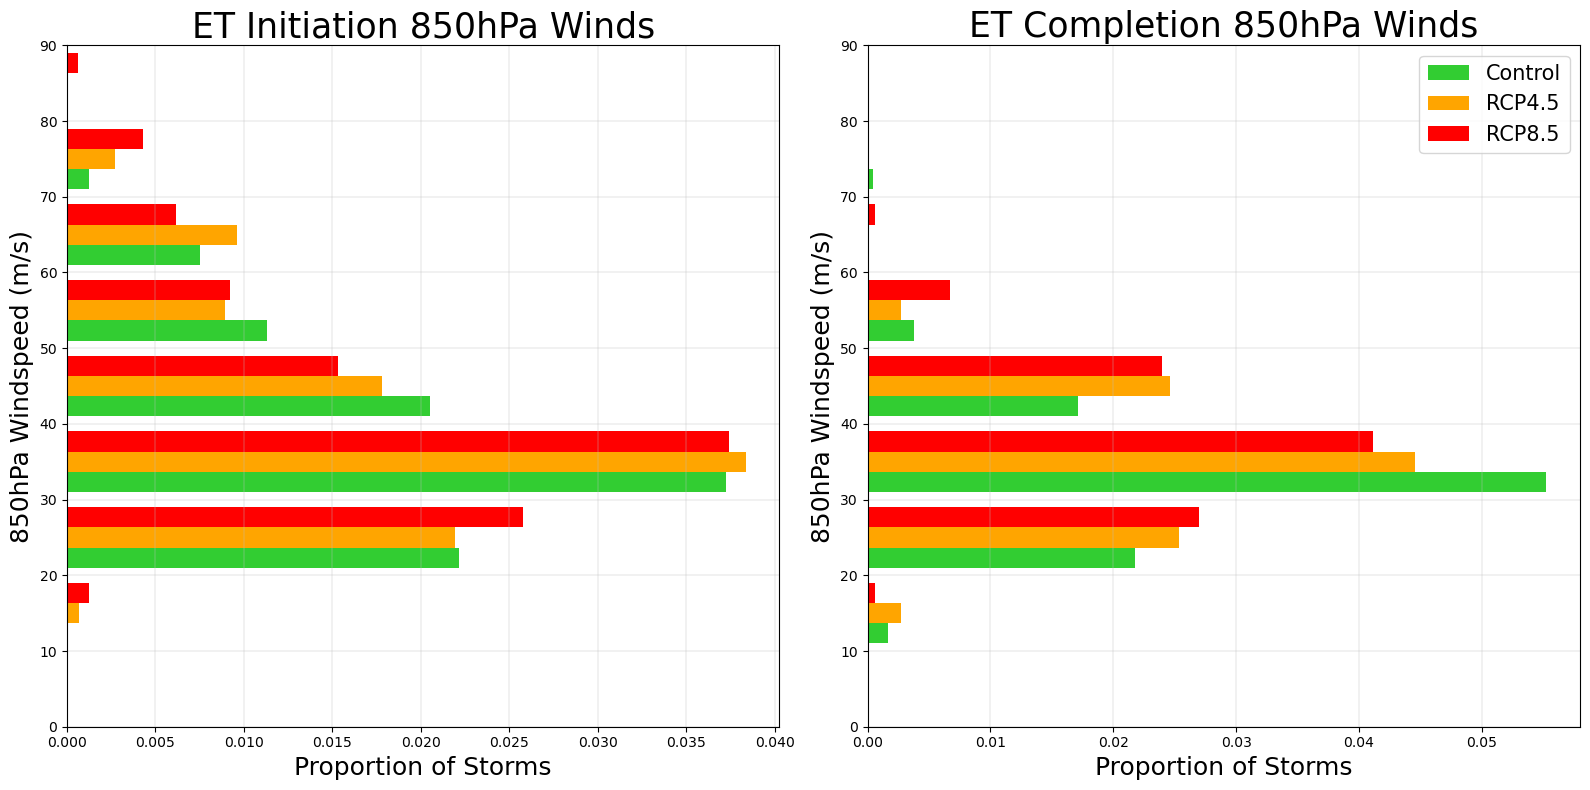

In [38]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"850hPa Winds", True, 'horizontal', Create_Bins(0,90,10), True, 'ET_850hPa_Winds_Histo.png')

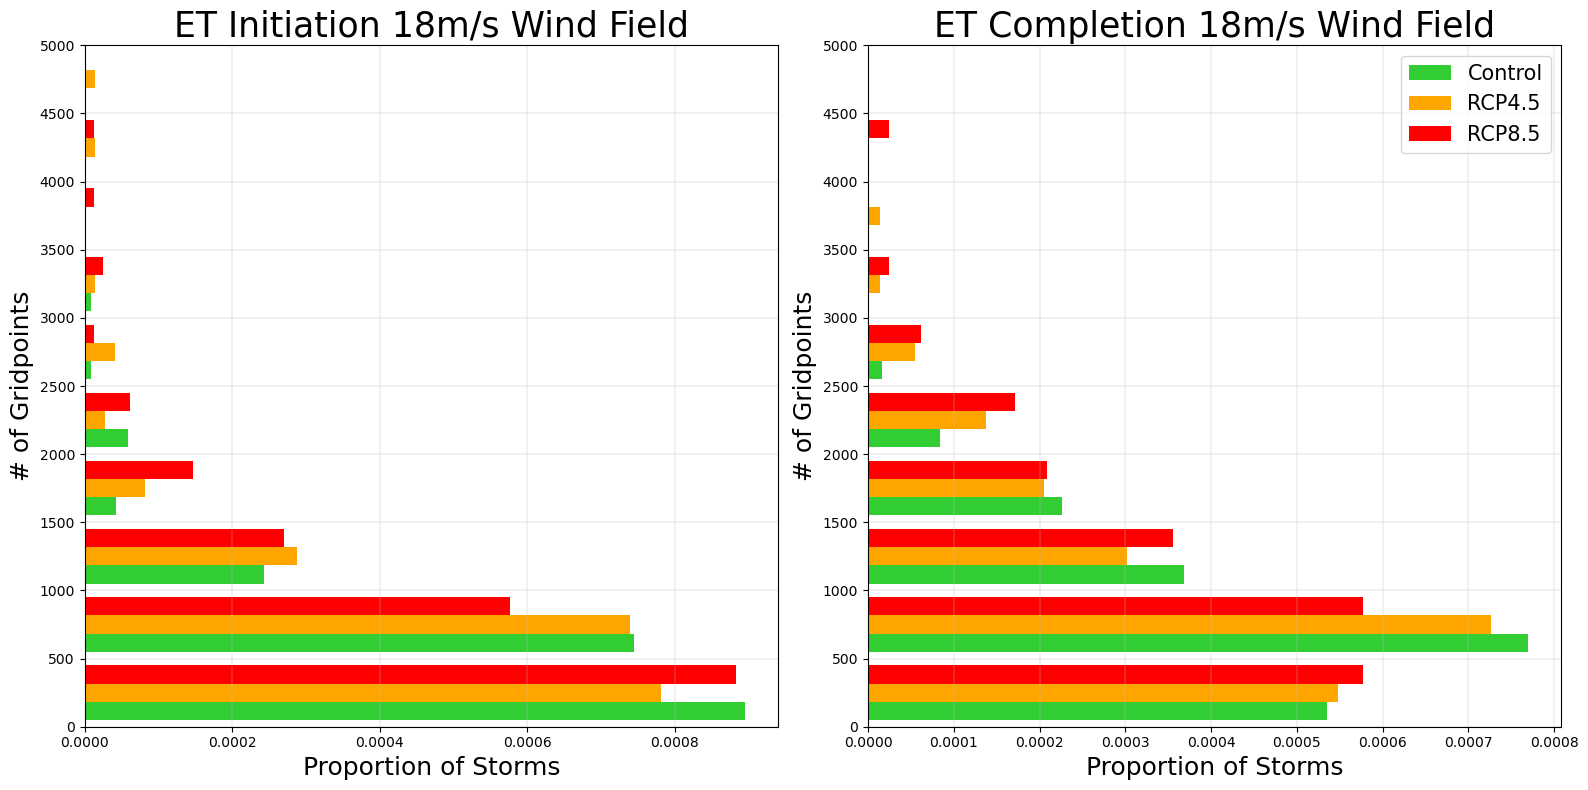

In [39]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"18m/s", True, 'horizontal', Create_Bins(0,5000,500), True, 'ET_18ms_Histo.png')

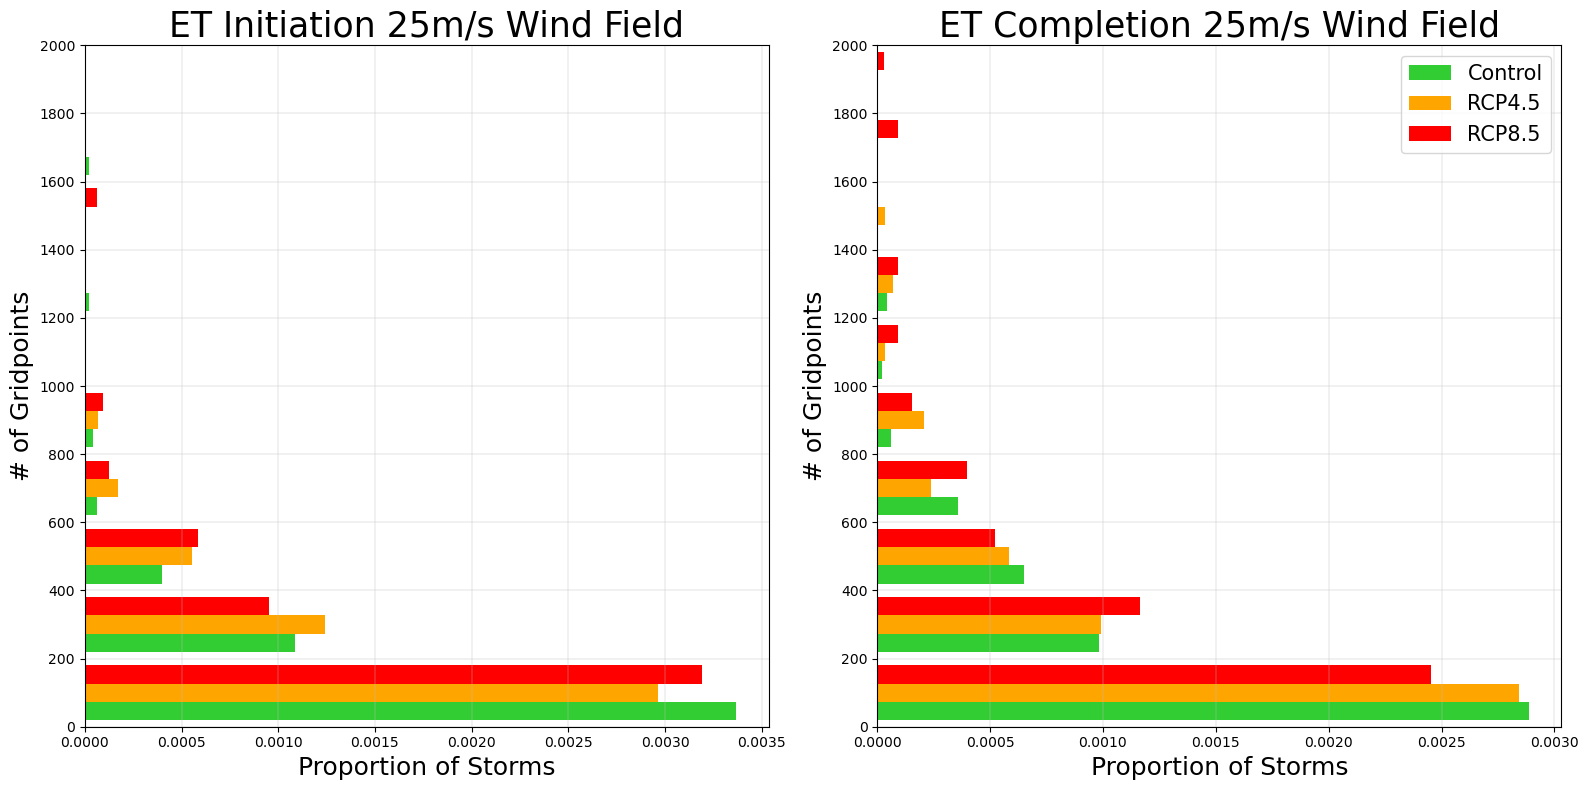

In [40]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"25m/s", True, 'horizontal', Create_Bins(0,2000,200), True, 'ET_25ms_Histo.png')

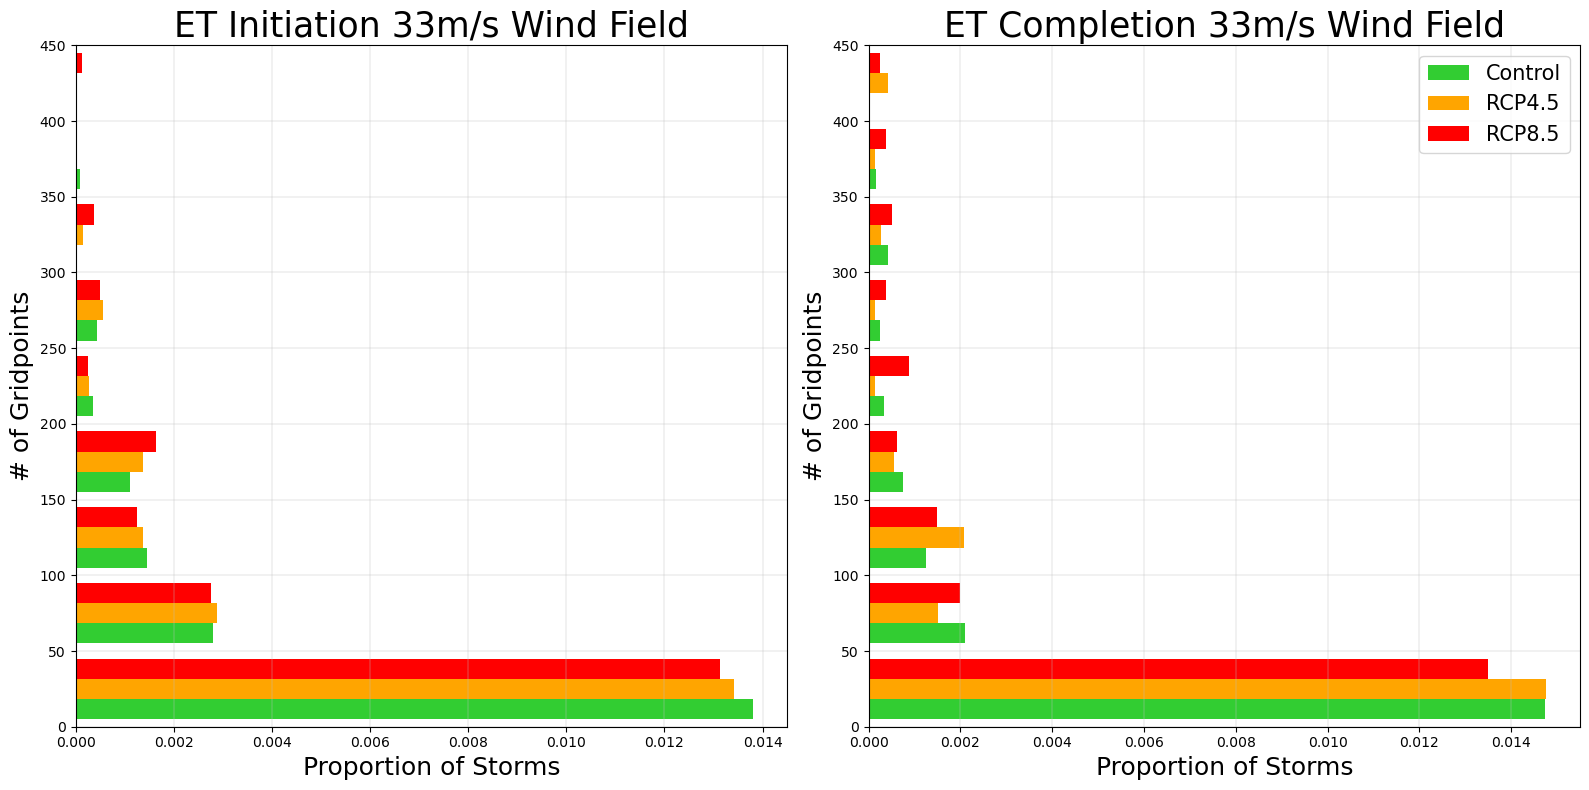

In [41]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"33m/s", True, 'horizontal', Create_Bins(0,450,50), True, 'ET_33ms_Histo.png')

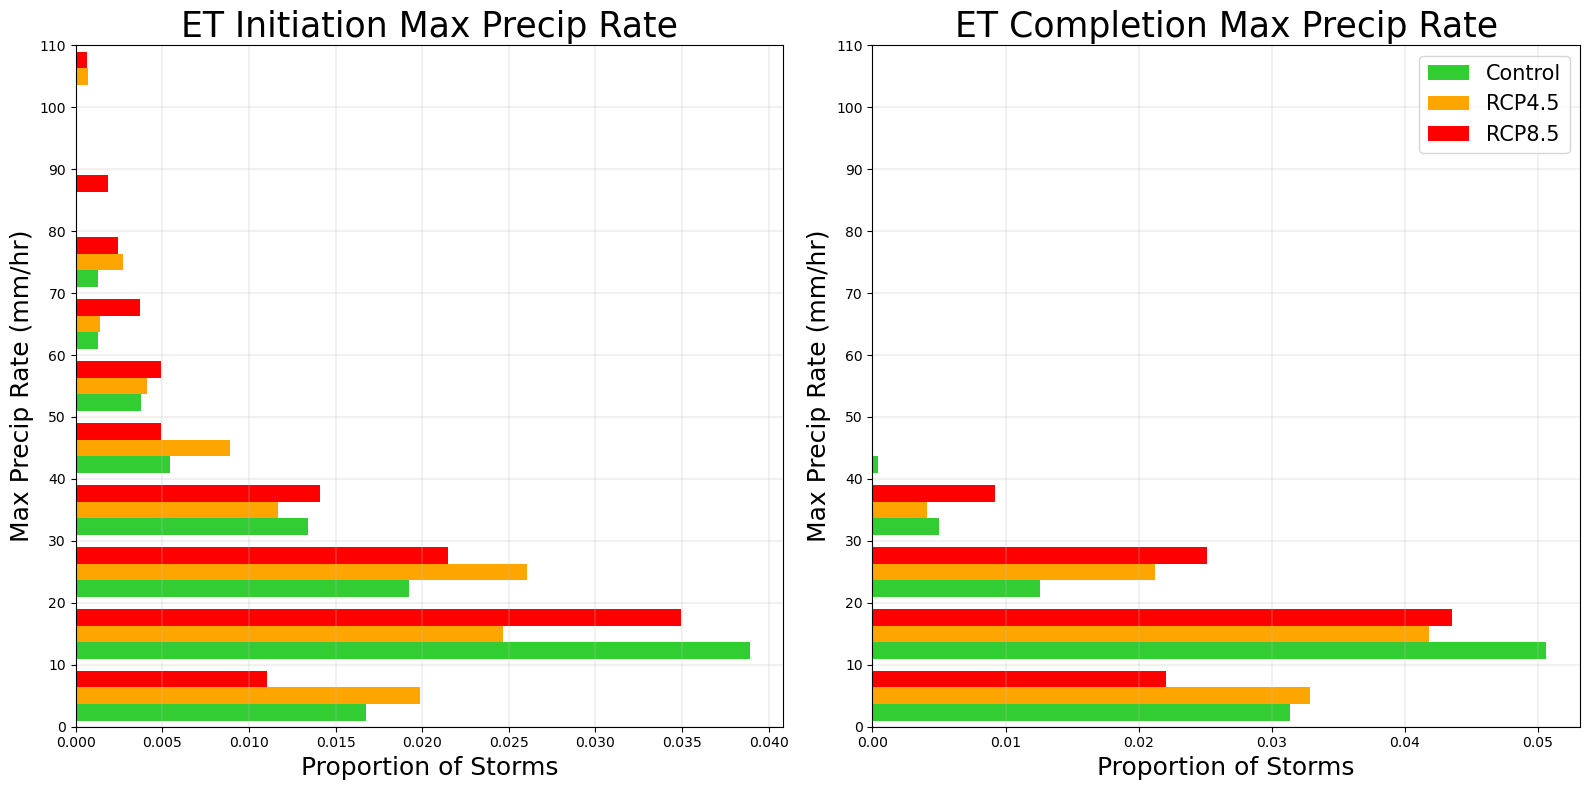

In [42]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"Max Precip Rate", True, 'horizontal', Create_Bins(0,110,10), True, 'ET_Precip_Rate_Histo.png')

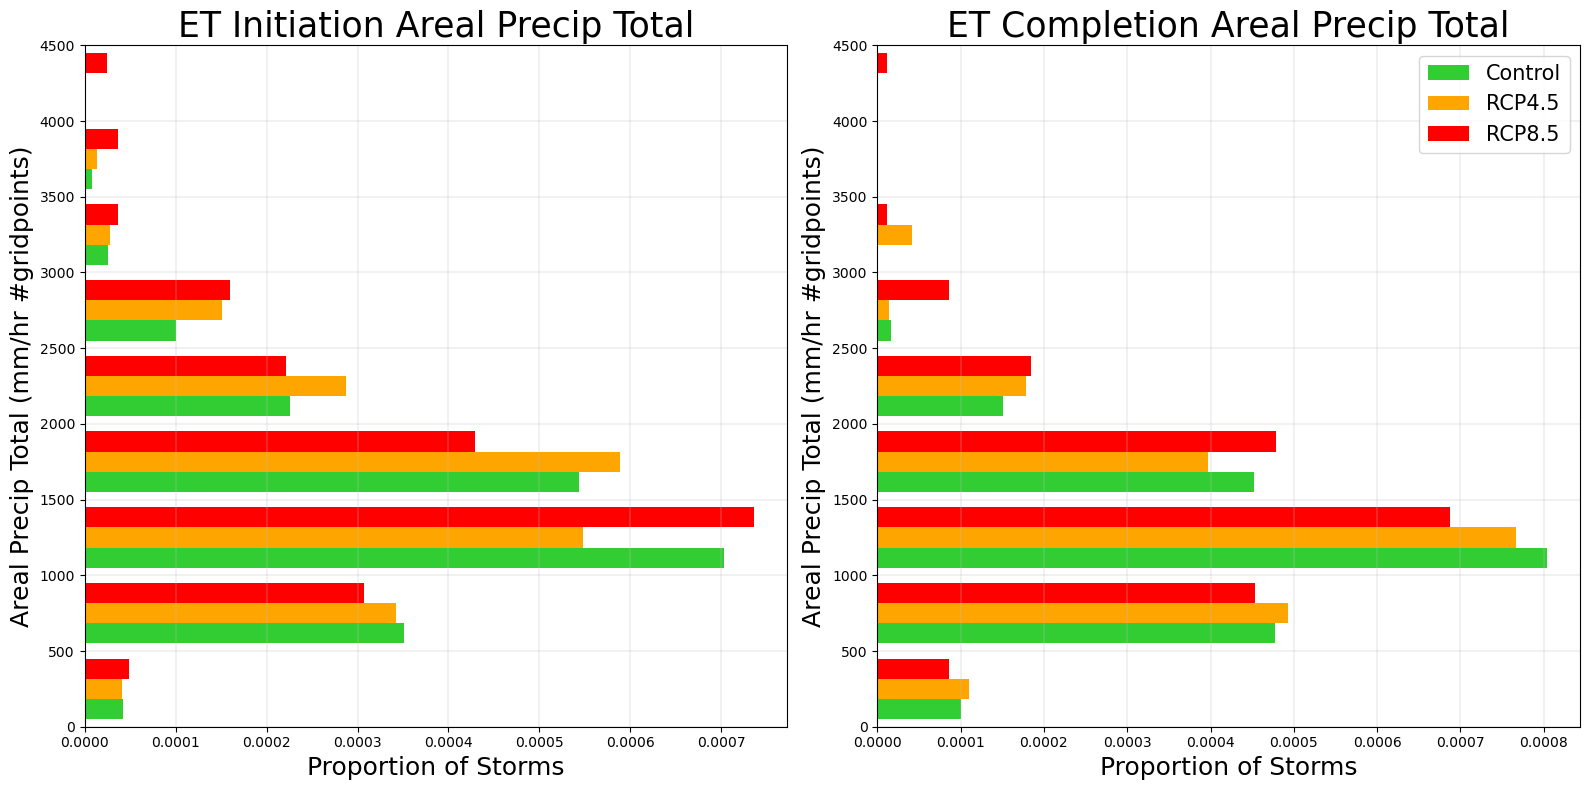

In [43]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"Areal Precip Total", True, 'horizontal', Create_Bins(0,4500,500), True, 'ET_Areal_Precip_Histo.png')

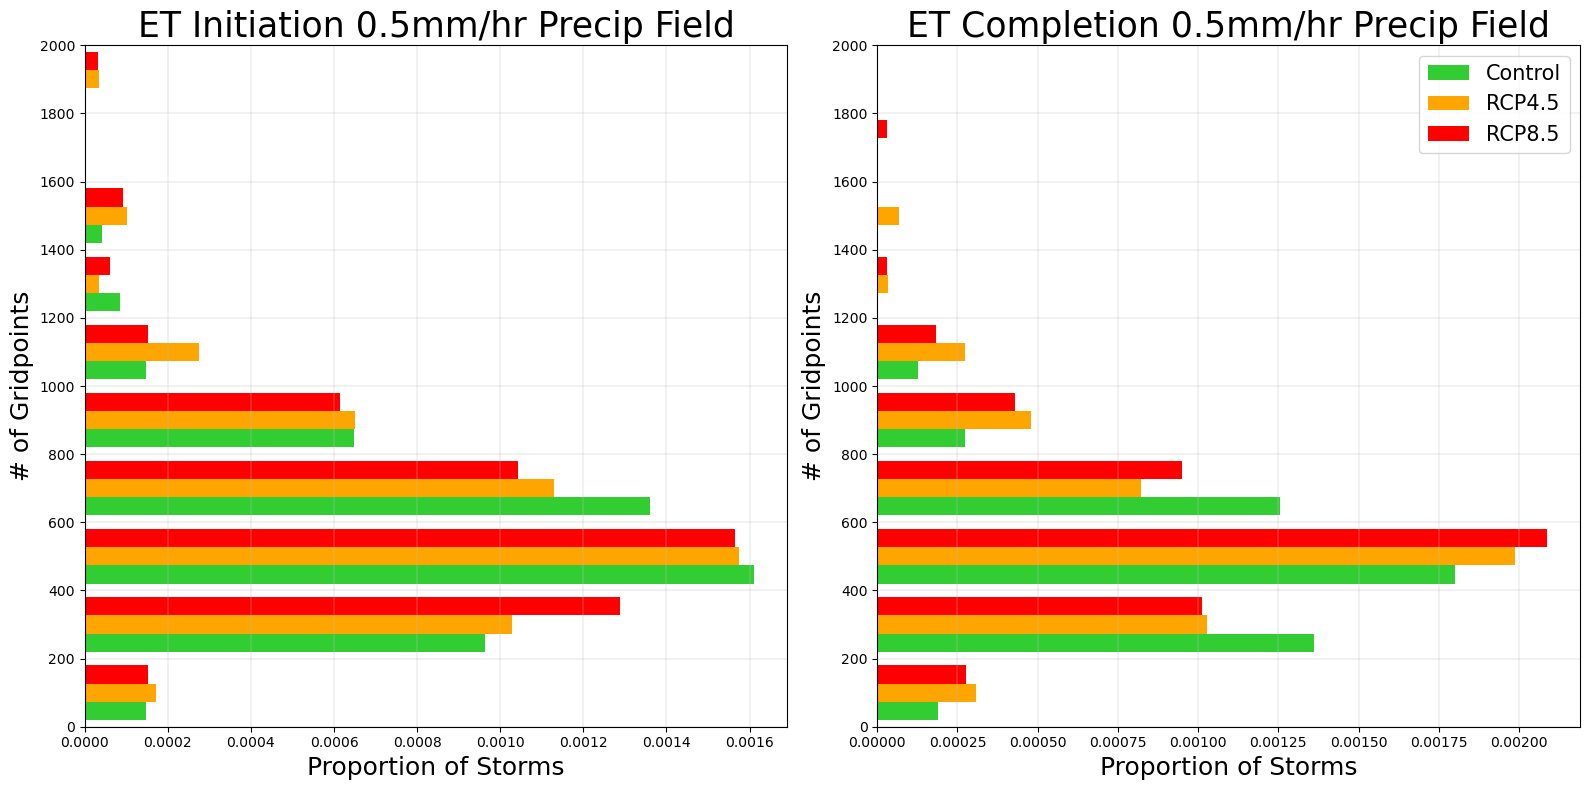

In [44]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"0.5mm/hr", True, 'horizontal', Create_Bins(0,2000,200), True, 'ET_0.5mmhr_Histo.png')

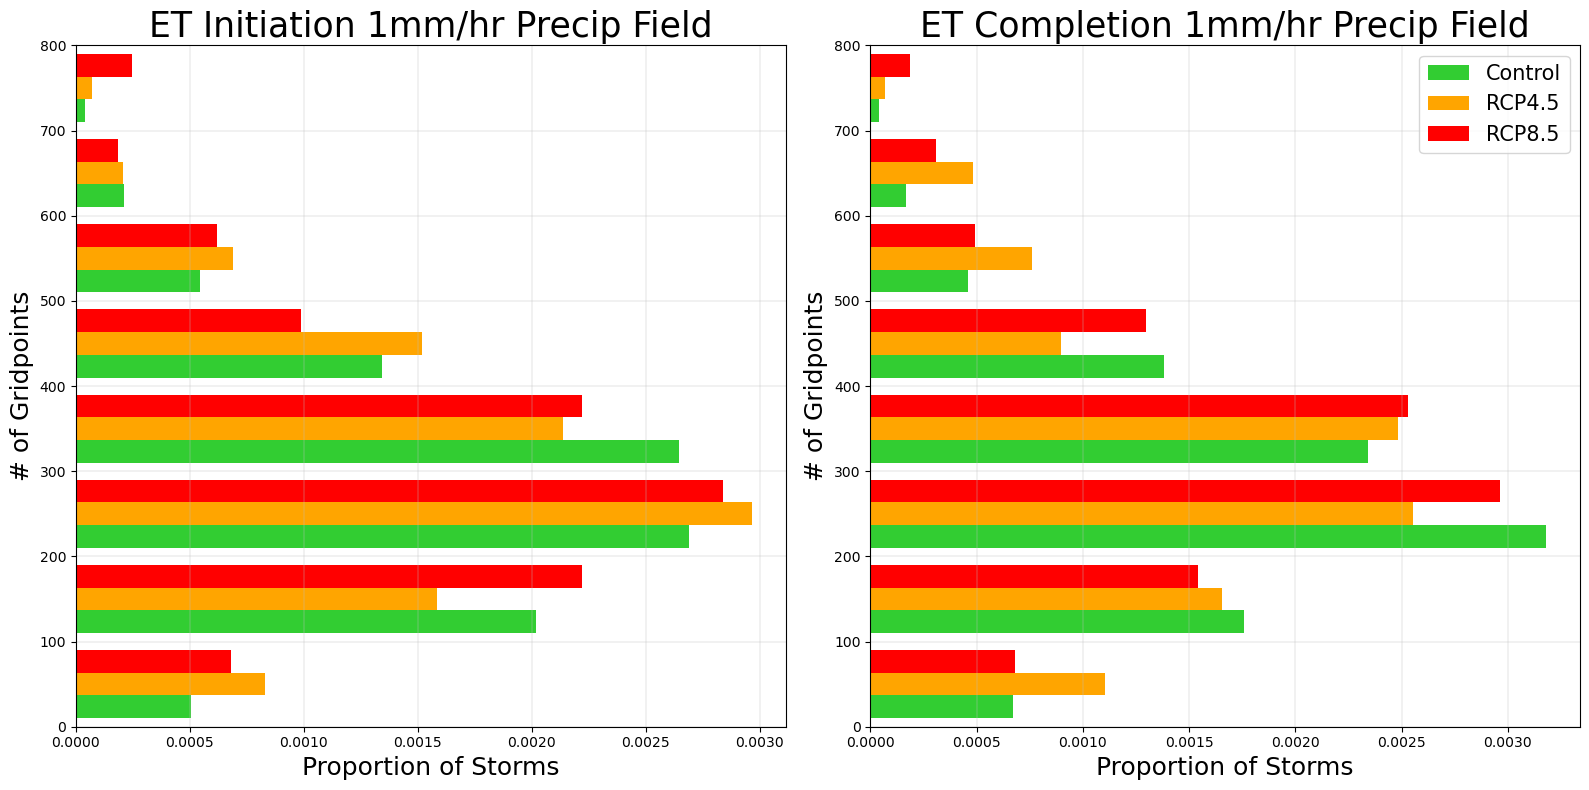

In [45]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"1mm/hr", True, 'horizontal', Create_Bins(0,800,100), True, 'ET_1mmhr_Histo.png')

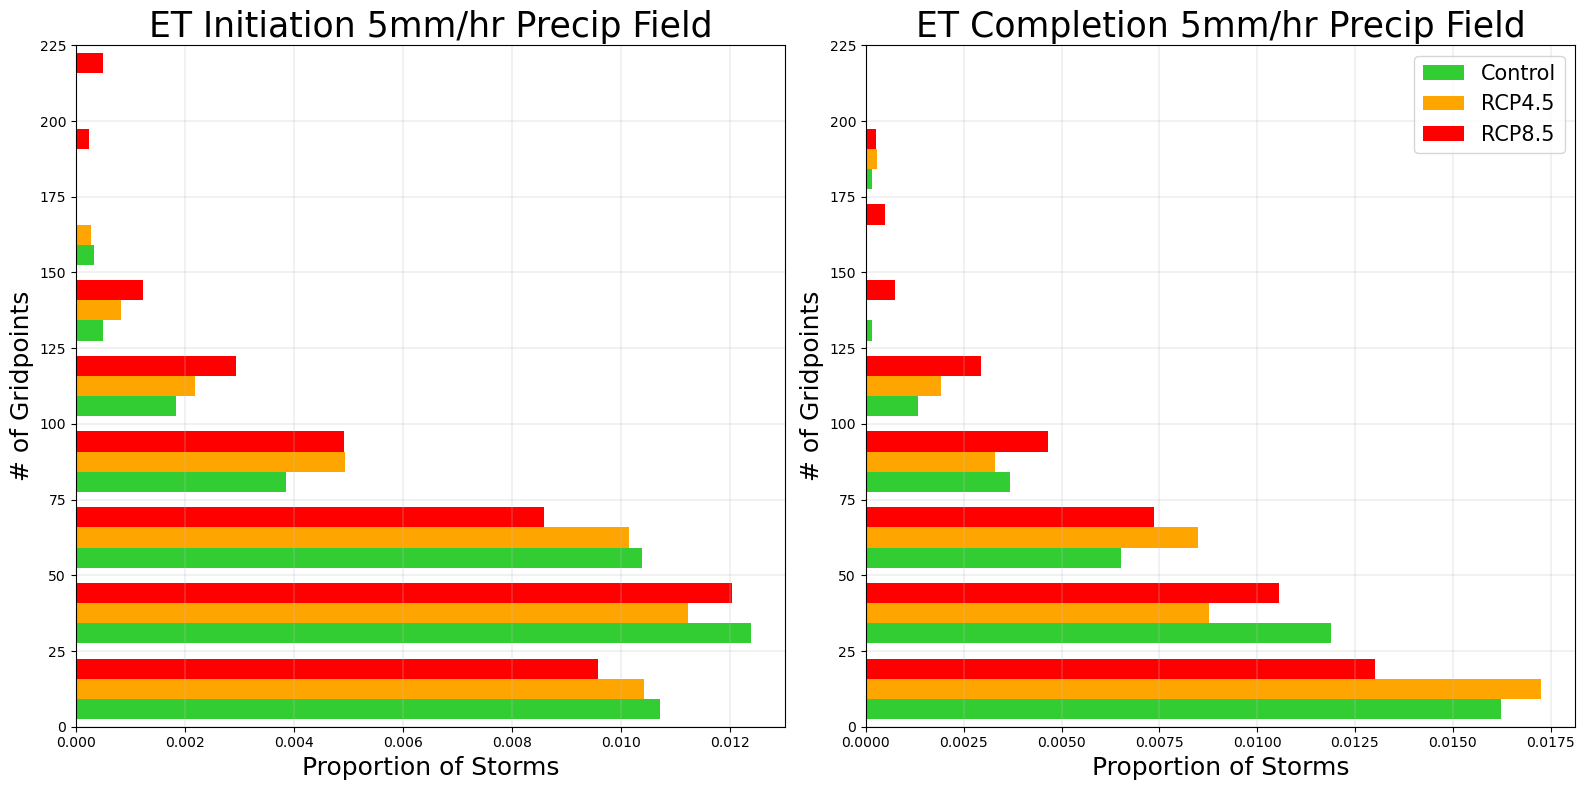

In [46]:
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"5mm/hr", True, 'horizontal', Create_Bins(0,225,25), True, 'ET_5mmhr_Histo.png')

In [47]:
# Create Function to Plot Boxplots
def ET_Compo_Boxplot(Control_ET, RCP45_ET, RCP85_ET, Var, Vert, Bins, Savefig, Figname):
    Fig = pyplot.figure(figsize=(10,10))
    if Vert == 1:
        Axes = Fig.subplots(1,3, sharex=False, sharey=True)
    elif Vert == 0:
        Axes = Fig.subplots(3,1, sharex=True, sharey=False)
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Plot Tropical Peak
    Var0 = "Trop Peak " + Var
    Boxplot0 = Axes[0].boxplot([Control_ET[Var0], RCP45_ET[Var0], RCP85_ET[Var0]], patch_artist=True, vert=Vert)
    ET_Compo_Boxplot_Formatting(Boxplot0, Axes[0], Var, Colours, Labels, Vert, Bins, 0)
#
# Plot ET Initiation
    Var1 = "ET Begin " + Var
    Boxplot1 = Axes[1].boxplot([Control_ET[Var1], RCP45_ET[Var1], RCP85_ET[Var1]], patch_artist=True, vert=Vert)
    ET_Compo_Boxplot_Formatting(Boxplot1, Axes[1], Var, Colours, Labels, Vert, Bins, 1)
#
# Plot ET Completion
    Var2 = "ET Complete " + Var
    Boxplot2 = Axes[2].boxplot([Control_ET[Var2], RCP45_ET[Var2], RCP85_ET[Var2]], patch_artist=True, vert=Vert)
    ET_Compo_Boxplot_Formatting(Boxplot2, Axes[2], Var, Colours, Labels, Vert, Bins, 2)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [48]:
# Formatting Based on Variable
def ET_Compo_Boxplot_Formatting(Boxplot, Axis, Var, Colours, Labels, Vert, Bins, i):
# Colours, Median, and Fliers
    for Patch, Colour in zip(Boxplot['boxes'], Colours): 
        Patch.set_facecolor(Colour)
    for Median in Boxplot['medians']: 
        Median.set(color='black', linewidth=1.8)
    for Flier in Boxplot['fliers']:
        Flier.set(marker='x', markersize=3.8, alpha=0.3)
#
# Ticks and Lims
    Axis.set_yticks(Bins)
    Axis.set_ylim(numpy.min(Bins), numpy.max(Bins))
#
# Labels and Title
    Axis.set_xticklabels(Labels, fontsize=12)
    if i == 0:
        if Var == "850hPa Winds":
            Axis.set_ylabel("850hPa Windspeed (m/s)", fontsize=14)
        elif Var == "Max Precip Rate":
            Axis.set_ylabel("Max Precip Rate (mm/hr)", fontsize=14)
        elif Var == "Areal Precip Total":
            Axis.set_ylabel("Areal Precip Total (mm/hr #gridpoints)", fontsize=14)
        else:
            Axis.set_ylabel("# of Gridpoints", fontsize=14)
            if Var == "18m/s" or Var == "25m/s" or Var == "33m/s":
                Title2 = " Wind Field"
            else:
                Title2 = " Precip Field"
        Title1 = "Tropical Peak "
    elif i == 1:
        Title1 = "ET Initiation "
    elif i == 2:
        Title1 = "ET Completion "
    try:
        Title = Title1 + Var + Title2
    except:
        Title = Title1 + Var
    Axis.set_title(Title, fontsize=14)
#
# Gridlines
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')

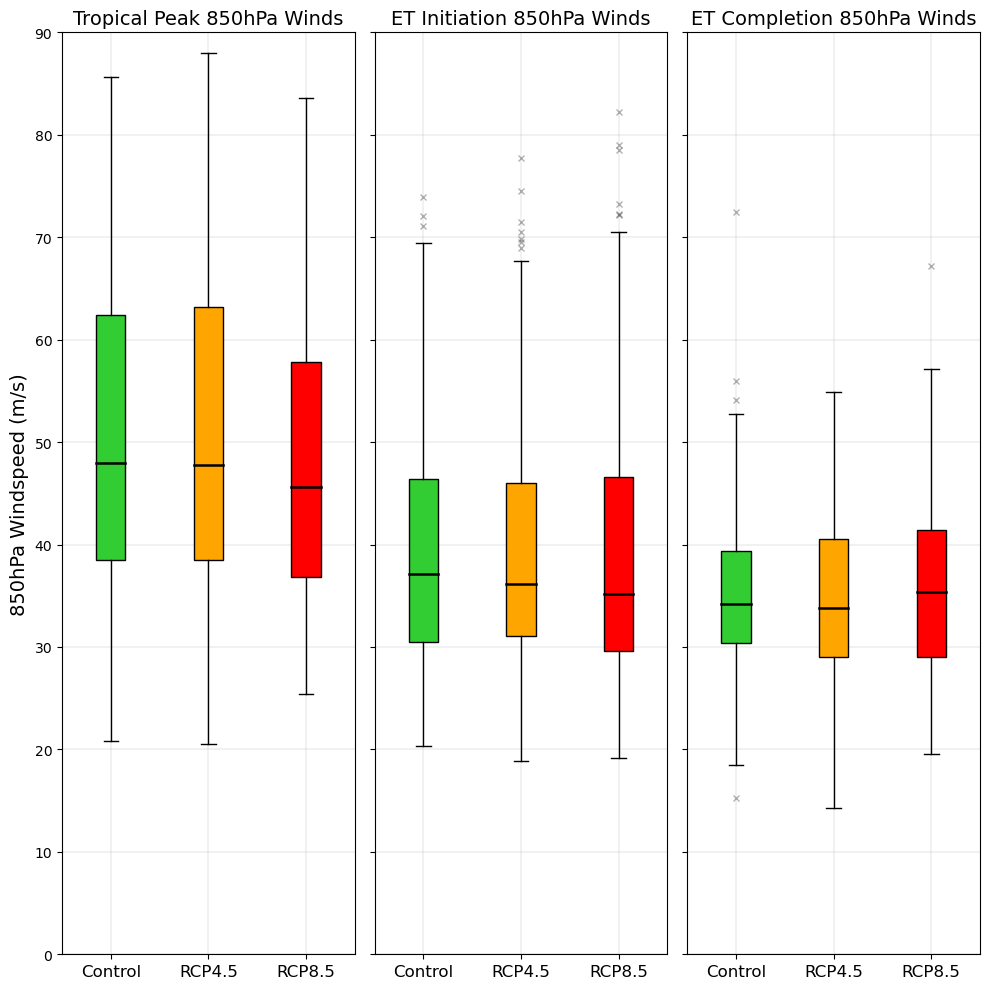

In [49]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"850hPa Winds", 1, Create_Bins(0,90,10), True, 'ET_850hPa_Winds_Boxplot.png')

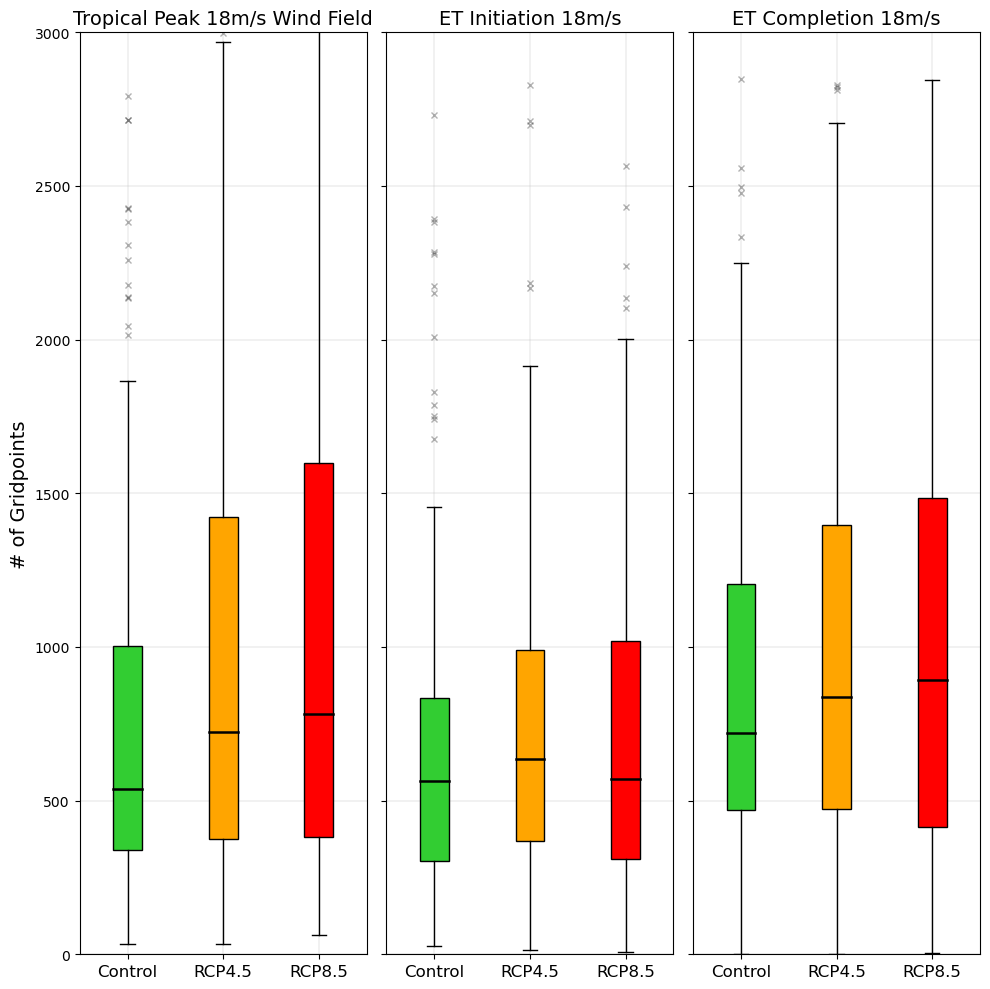

In [50]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"18m/s", 1, Create_Bins(0,3000,500), True, 'ET_18ms_Boxplot.png')

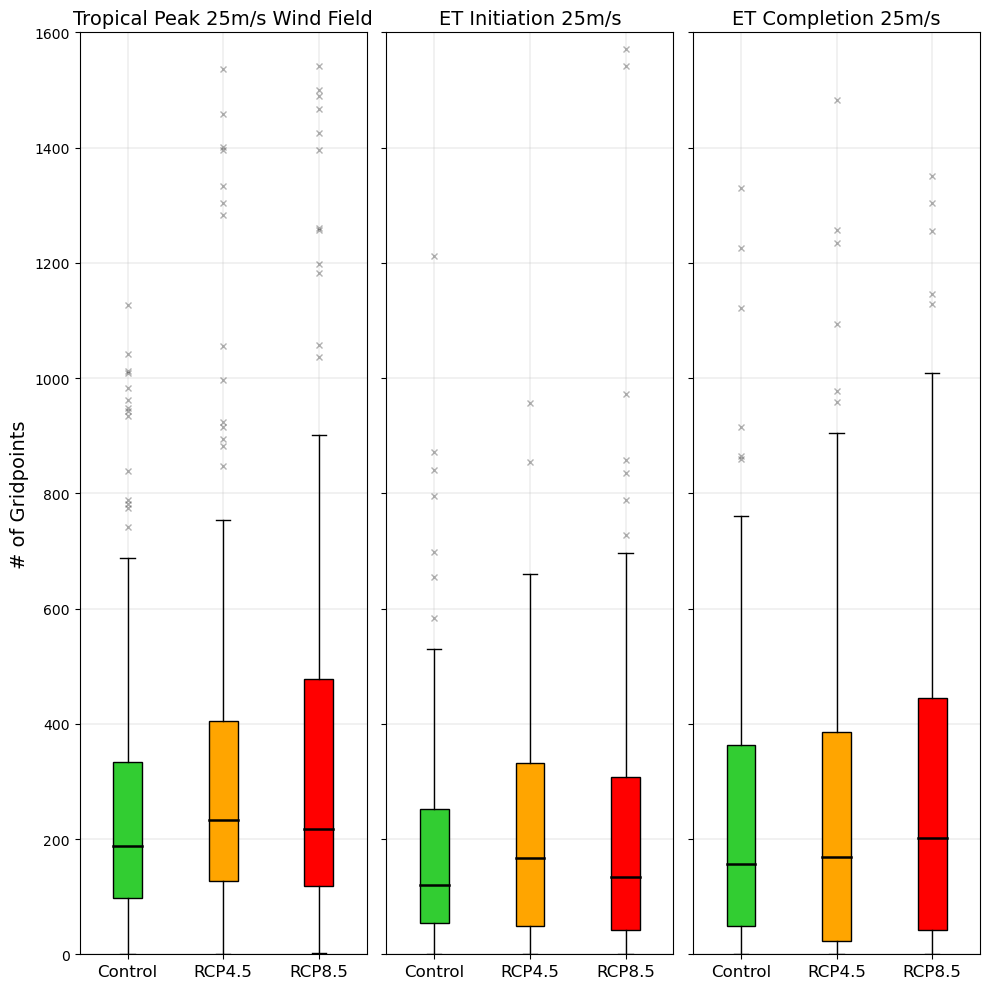

In [51]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"25m/s", 1, Create_Bins(0,1600,200), True, 'ET_25ms_Boxplot.png')

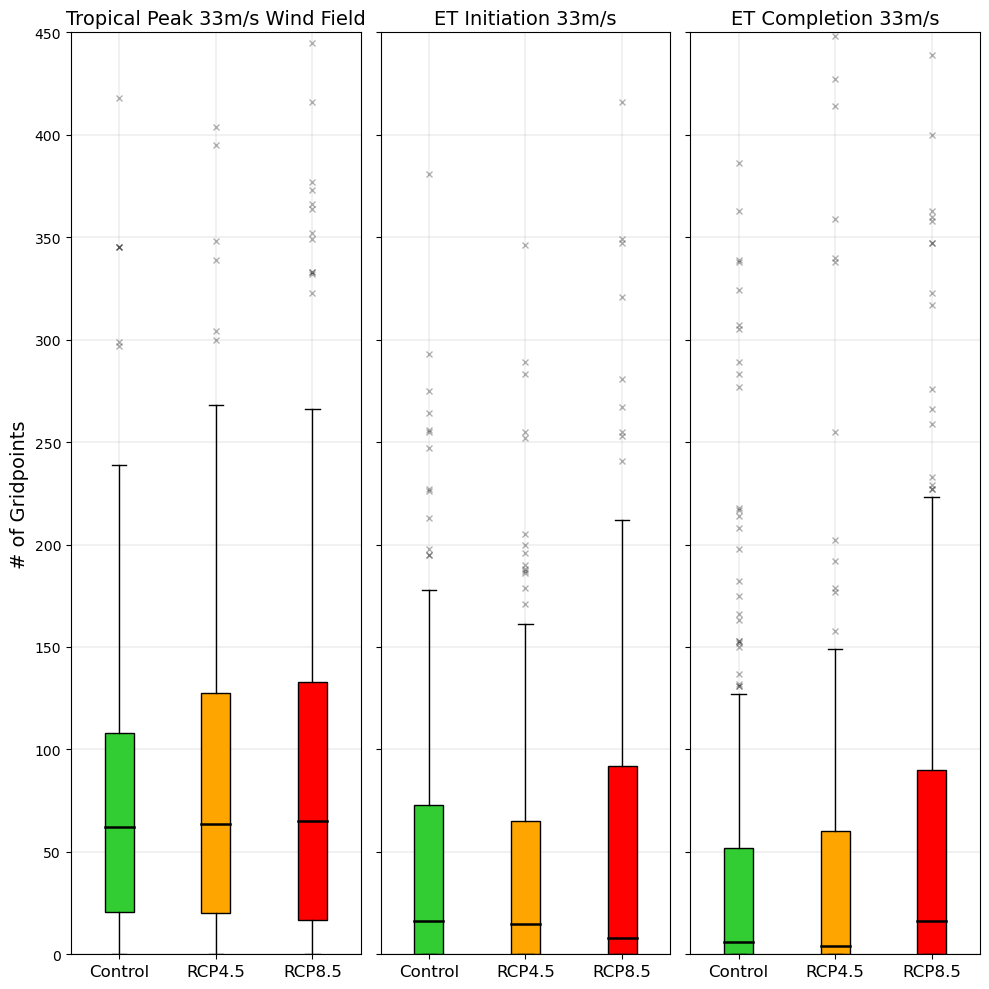

In [52]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"33m/s", 1, Create_Bins(0,450,50), True, 'ET_33ms_Boxplot.png')

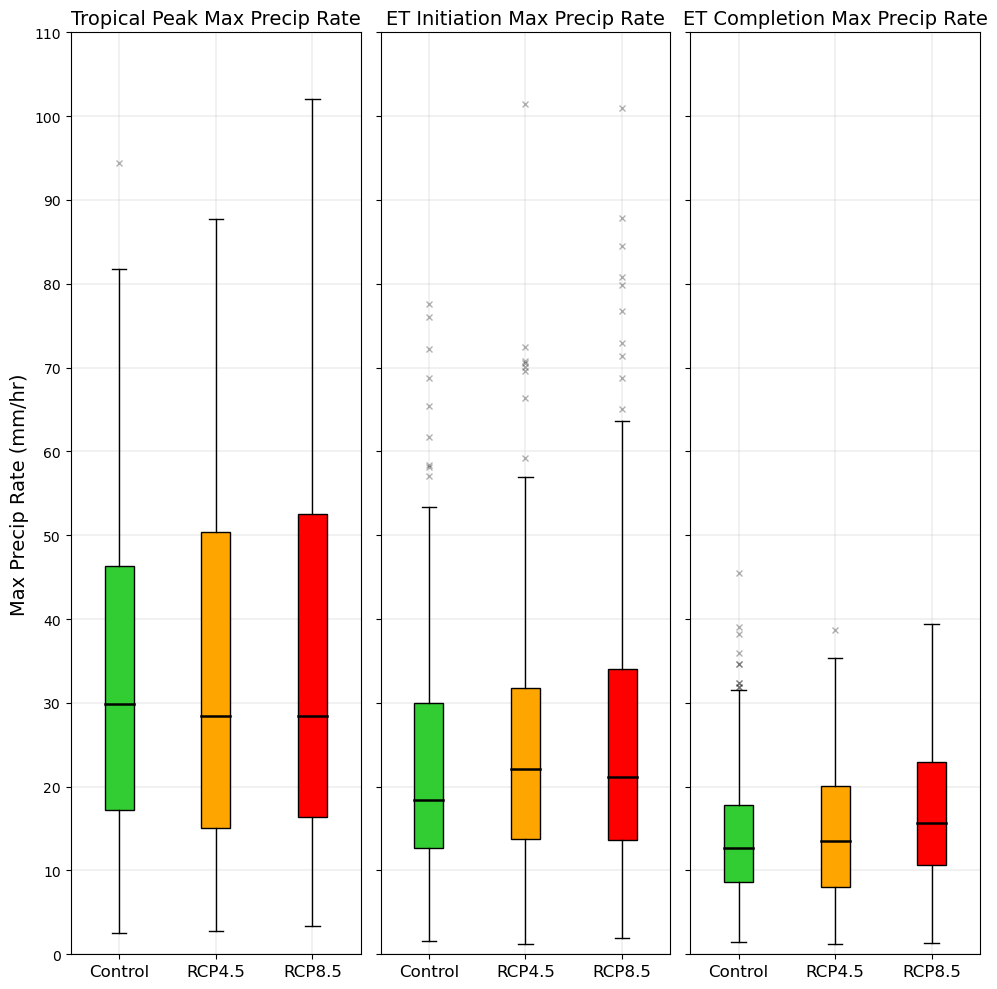

In [53]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"Max Precip Rate", 1, Create_Bins(0,110,10), True, 'ET_Precip_Rate_Boxplot.png')

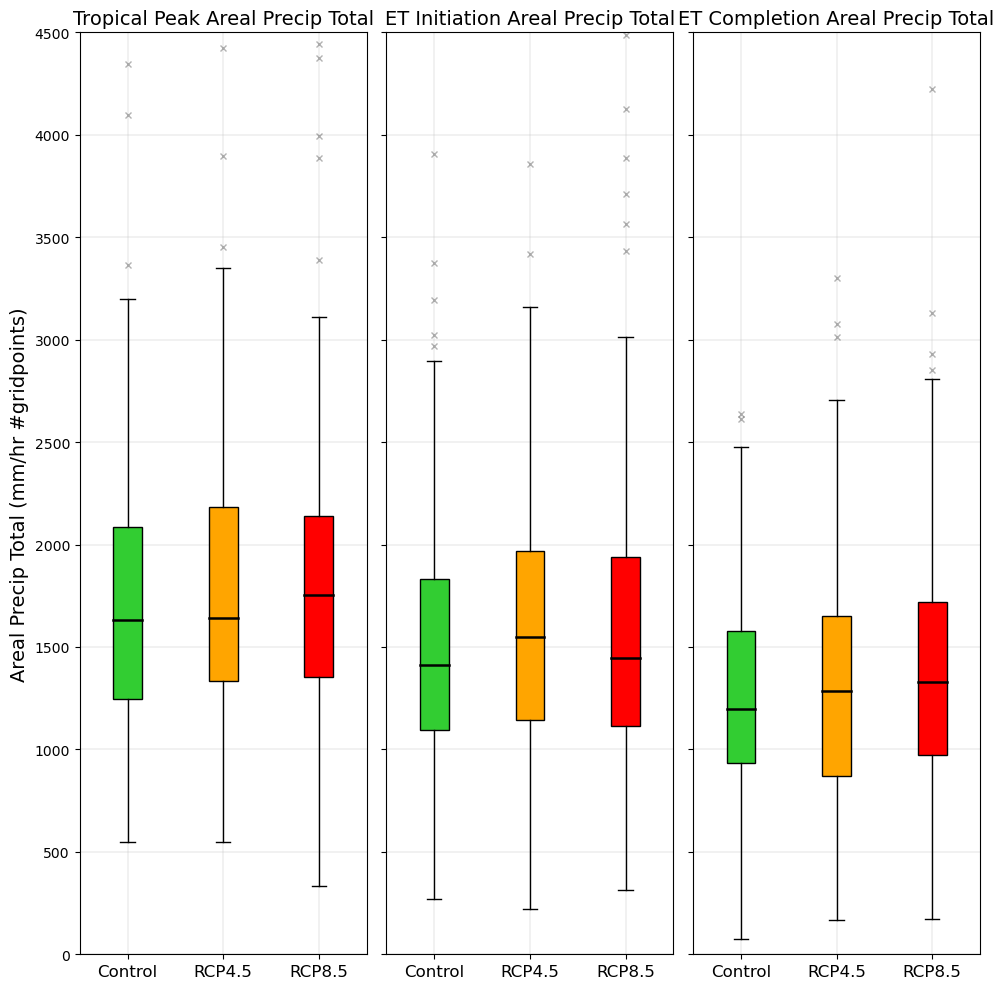

In [54]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"Areal Precip Total", 1, Create_Bins(0,4500,500), True, 'ET_Areal_Precip_Boxplot.png')

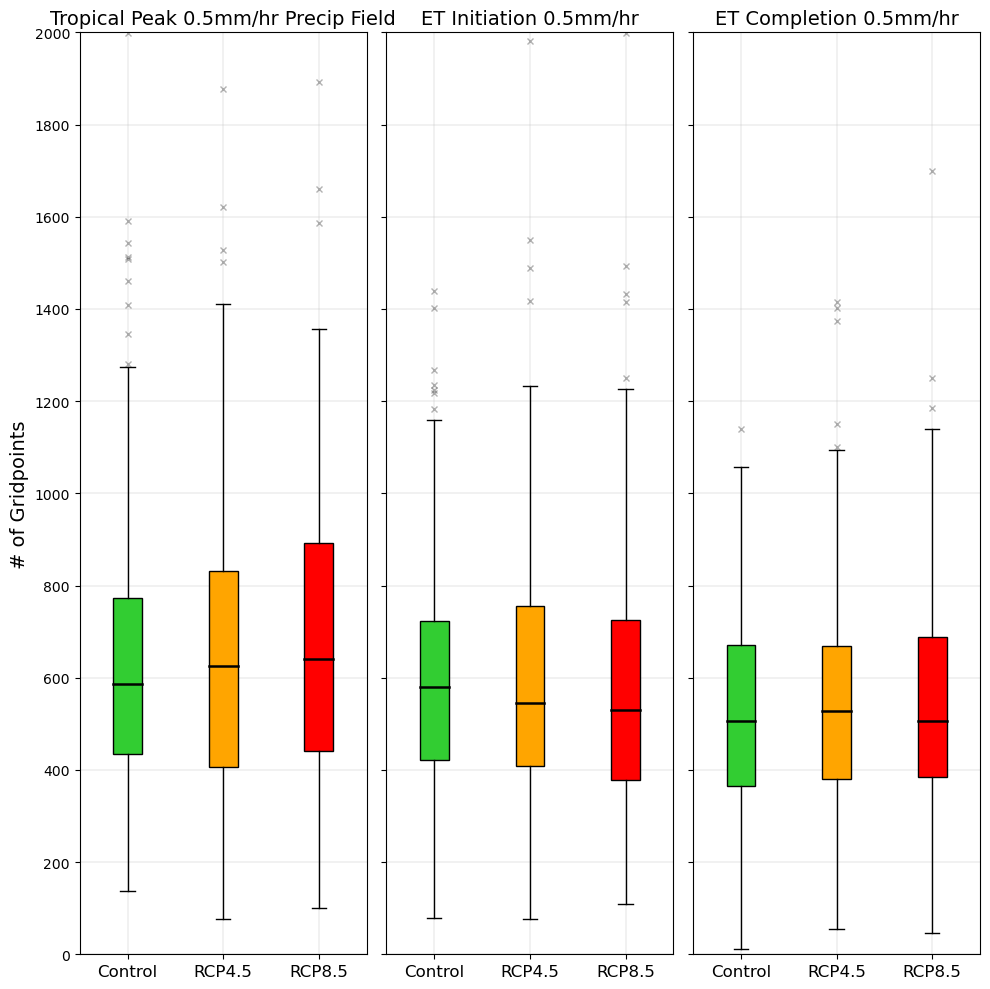

In [55]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"0.5mm/hr", 1, Create_Bins(0,2000,200), True, 'ET_0.5mmhr_Boxplot.png')

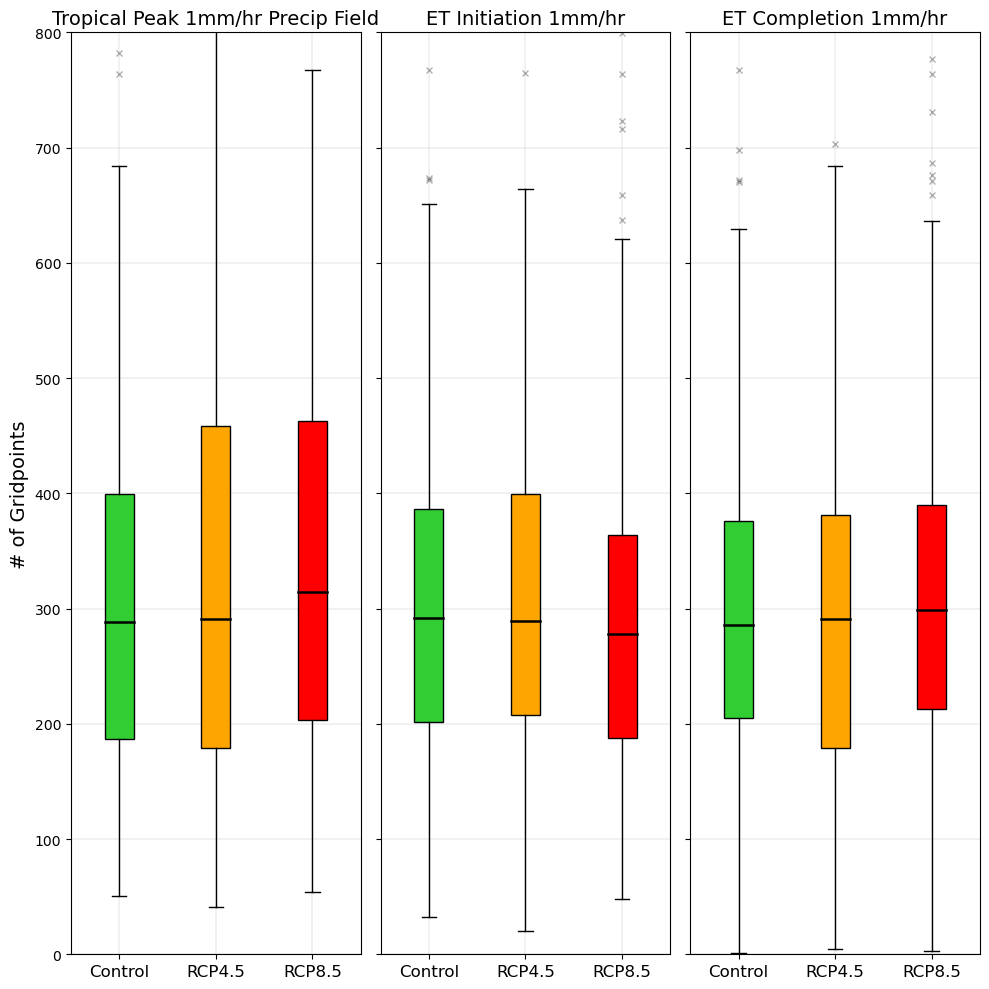

In [56]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"1mm/hr", 1, Create_Bins(0,800,100), True, 'ET_1mmhr_Boxplot.png')

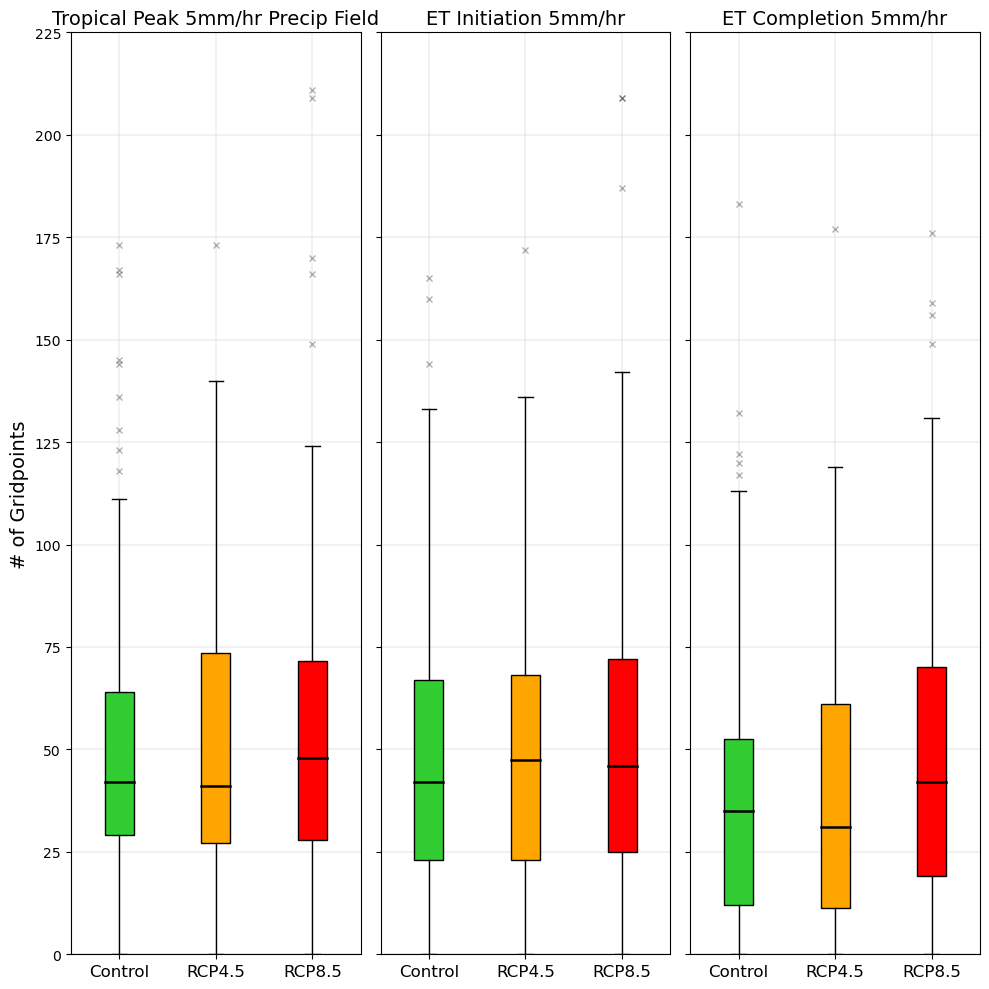

In [57]:
ET_Compo_Boxplot(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
"5mm/hr", 1, Create_Bins(0,225,25), True, 'ET_5mmhr_Boxplot.png')